# Técnica de validación para series temporales
---

La mayoría de las técnicas de validación cruzada no son correctas cuando abordamos un problema de series temporales. El remuestreo de **bootstrapping**, **k-fold** o **k-fold estratificado** baraja los datos y no garantiza que haya la misma coherencia en sus pliegues de validación en comparación con su conjunto de prueba real. De hecho, hay que recordar que los datos de prueba estarán en un período del futuro.

La mayoría de los modelos de series temporales también crecen en tamaño. Por ejemplo, nuestros datos del conjunto de entrenamiento crecen cada período de tiempo. Podríamos estar prediciendo a corto plazo o extrapolarlo a algún horizonte _h_ dependiendo de si estamos utilizando modelos clásicos de series de tiempo (modelos autoregresivos), aprendizaje automático o redes neuronales. Además, la mayoría de las veces el modelo necesita ser entrenado con los nuevos datos antes de poder pronosticas el horizonte *h* nuevamente.

Esto lleva a utilizar la estrategia de validación conocida como: **Walk Forward Validation** o validación cruzada de avance.


## Walk Forward Validation
---
Con esto en mente, la división del conjunto de datos en conjunto de aprendizaje y conjunto test habitual funcionará mejor que los enfoques *k*-fold. Sin embargo, esta división habitual podría no ser un buen indicador ya que es posible que deseemos evitar un ajuste excesivo a una división particular. Es decir, el 'donde' se divida juega un papel importante en el resultado de validación.

Para evitar la suerte como factor y tener un resultado más sóido, podemos ampliar este concepto haciendo lo que se conoce como *validación de avance*.

![image.png](walk_forward_1.PNG)

El profesor **_Rob Hyndman_** ilustra este concepto muy bien con el diagrama anterior. De hecho, estamos haciendo una división múltiple en los diferentes períodos de tiempo, con los datos de entrenamiento expandiéndose cada vez. Posteriormente, promediamos el rendimiento en los distintos pliegues según la métrica que se decida (*MAPE*, *WMPAE*, etc.)

Por supuesto, esta estrategia no se limita a expandirse solo por un período. Dependiendo de la frecuencia de sus datos, el tipo de modelo o incluso el objetivo a tratar, es posible que se desee definir una longitud inicial diferente, un período de ganancia de datos y un horizonte para validar.

![image.png](walk_forward.PNG)

## Código: R y Python
---

El profesor *Hyndman* diseño un paquete en R donde llamando a la función **_tsCv_** podremos indicar la ventana deslizante *window* así como el nº de registros a predecir, *h*.

    e <- tsCv(lynx, far2, h=1, window=30)
    
Para **Python** no hay tanta suerte. Usando *sklearn*, existe una división de series temporales `TimeSeriesSplit`. Sin embargo, esta funciín no permite diseñar un período inicial para el entrenamiento. Si nosotros queremos entrenar con mínimo 2-3 años, tendremos que definir un período que se agregará en cada iteración, así como el horizonte *h*. La versión de *sklearn* sólo nos permite definir el nº de pliegues, *n_splits*.


    >>> import numpy as np
    >>> from sklearn.model_selection import TimeSeriesSplit
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4, 5, 6])
    >>> tscv = TimeSeriesSplit()
    >>> print(tscv)
    TimeSeriesSplit(max_train_size=None, n_splits=5)
    >>> for train_index, test_index in tscv.split(X):
    ...     print("TRAIN:", train_index, "TEST:", test_index)
    ...     X_train, X_test = X[train_index], X[test_index]
    ...     y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    TRAIN: [0 1 2 3] TEST: [4]
    TRAIN: [0 1 2 3 4] TEST: [5]
    
Así definimos una función que permite la funcionalidad de la ventana deslizante:

In [6]:
class expanding_window(object):
    
    def __init__(self, initial = 1, horizon = 1, period = 1):
        """
            Constructor
            
            @param: initial Longitud inicial del entrenamiento
            @param: horizon Longitud (nº registros) de la predicción
            @param: period Longitud del conjunto de entrenamiento a incluir para cada próxima iteracion+
        """
        self.initial = initial
        self.horizon = horizon
        self.period = period
        
    def split(self, data):
        """
            Función que construye el conjunto entrenamiento-test para cada iteración de la estrategia definida
            
            @param: data Conjunto de entrenamiento
        """
        self.data = data
        self.counter = 0
        
        data_length = data.shape[0] # número de registros
        data_index = list(np.arange(data_length)) # lista de índices de cada observación del dataset
        
        output_train = []
        output_test = []
        
        output_train.append(list(np.arange(self.initial))) # primer conjunto train
        progress = [x for x in data_index if x not in list(np.arange(self.initial))]
        # primer conjunto test tomando los h registros siguientes al primer conjunto train
        output_test.append([x for x in data_index if x not in output_train[self.counter]][:self.horizon])
        
        while len(progress) != 0:
            temp = progress[:self.period]
            to_add = output_train[self.counter] + temp
            # con period=1 estamos incluyendo un registro del conjunto de testeo en cada próxima iteración del train
            
            # actualizamos los índices del train
            output_train.append(to_add)
            
            # incrementamos el conteo
            self.counter += 1
            
            # actualizamos los índices del test
            to_add_test = [x for x in data_index if x not in output_train[self.counter] ][:self.horizon]
            output_test.append(to_add_test)
            
            # actualizamos el proceso
            # vamos eliminado los índices posibles a ingestar hasta quedarnos con ningún índice en el test y todos en el train
            progress = [x for x in data_index if x not in output_train[self.counter]]
            
        # elimimamos el último elemento del output_train y output_test (no nos interesa tener un train = full y test = [])
        output_train = output_train[:-1]
        output_test = output_test[:-1]
        
        # preparamos la salida (similar a sklearn)
        index_output = [(train, test) for train, test in zip(output_train, output_test)]
        
        return index_output

### Implementación
---

In [7]:
import numpy as np

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])

tscv = expanding_window()
for train_index, test_index in tscv.split(X):
    print("Train:", train_index, " Test:", test_index)

Train: [0]  Test: [1]
Train: [0, 1]  Test: [2]
Train: [0, 1, 2]  Test: [3]
Train: [0, 1, 2, 3]  Test: [4]
Train: [0, 1, 2, 3, 4]  Test: [5]


> Modificamos ahora los parámetros de entrada para considerar una ventana inicial de conjunto de entrenamiento superior a 1 y un conjunto test superior a 1 en cada iteración:

In [8]:
X = np.random.randint(0,1000,size = (120,2))
y = np.random.randint(0,1000,size = (120,1))

tscv = expanding_window(initial = 36, horizon = 24, period = 1)
for train_index, test_index in tscv.split(X):
    print("Train:", train_index) 
    print("Test:", test_index)

Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
Test: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
Test: [37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
Test: [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
Test: [39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 

### Caso de uso. Consumo Madrid 2019
---

* **Parámetros a configurar**

In [9]:
business_id = "918df303-e762-4a90-9ea1-5b78e1911f54"
region = "Madrid"

* **Descarga de datos**

In [10]:
from onesaitplatform.iotbroker import DigitalClient

import json
from pandas.io.json import json_normalize

HOST = "sofia2-shsb-dev-sib"
PORT = 90
ONTOLOGY_CONSUMO = "SmartEneryProsumers_Measures"
ONTOLOGY_METEO = "MeteoData"
IOT_CLIENT = "Forecasting_SmartEnergyProsumers"
IOT_CLIENT_TOKEN = "3d103f50114a4c69bb013c55b81f618f"

class DataCollection(object):
    """
        Clase que implementa el proceso de recopilación de datos
    """
    def __init__(self, host, port, ontology, token, digital_client, conditions = ""):
        """
            Constructor
            
            @param: host Máquina de conexión
            @param: ontology Ontologia de consulta donde se almacenan los datos descargados y procesados
            @param: token Token para creación de cliente e inserción en ontología de plataforma
            @param: digital_client DigitalClient para autorización de conexión a ontologia
            @param: conditions Condiciones impuestas sobre la query de conexión a la BBDD
        """
        self.host = host
        self.port = port
        self.ontology = ontology
        self.token = token
        self.digital_client = digital_client
        self.conditions = conditions
        self.init_digital_client()
        
    def init_digital_client(self):
        self.client = DigitalClient(host=self.host, port=self.port, iot_client=self.digital_client, iot_client_token=self.token)
        self.client.protocol = "http"
        self.client.avoid_ssl_certificate = True
        self.client.join()
        
    def download(self):
        ok_join = True
        if not self.client.is_connected:
            ok_join, res_join = self.client.join()
        if ok_join:
            query = "select * from " + self.ontology + self.conditions
            ok_query, results_query = self.client.query_batch(ontology=self.ontology, query = query, 
                                                              query_type = 'SQL', batch_size = 2000)
            if ok_query:
                results_pd = json_normalize(results_query)
                results_pd = results_pd[[c for c in results_pd.columns if c.find(u'contextData')]]
        return results_pd

obj_consumo = DataCollection(HOST, PORT, ONTOLOGY_CONSUMO, IOT_CLIENT_TOKEN, IOT_CLIENT, 
                             ' as c where c.business_id = "' + str(business_id) + '" order by c.timestamp ASC')
data_consumo = obj_consumo.download()

obj_meteo = DataCollection(HOST, PORT, ONTOLOGY_METEO, IOT_CLIENT_TOKEN, IOT_CLIENT, 
                ' as c where c.' + ONTOLOGY_METEO + '.region = "' + str(region) + '"')
data_meteo = obj_meteo.download()

* **Descripción de datos**

In [11]:
data_meteo['MeteoData.fecha'].tail()

8755    2019-12-31 19:00:00
8756    2019-12-31 20:00:00
8757    2019-12-31 21:00:00
8758    2019-12-31 22:00:00
8759    2019-12-31 23:00:00
Name: MeteoData.fecha, dtype: object

In [12]:
data_consumo['value.timestamp'].tail()

8755    2019-12-31 19:00:00
8756    2019-12-31 20:00:00
8757    2019-12-31 21:00:00
8758    2019-12-31 22:00:00
8759    2019-12-31 23:00:00
Name: value.timestamp, dtype: object

In [13]:
data_consumo['value.value'].describe()

count    8760.000000
mean      568.676256
std       376.962457
min         0.000000
25%       272.000000
50%       313.000000
75%       913.000000
max      1692.000000
Name: value.value, dtype: float64

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,5))
sns.distplot(data_consumo['value.value'], color = "darkred")
plt.title('Distribución de la variable objetivo')
plt.show()

<Figure size 1000x500 with 1 Axes>

* **Preparación de los datos**

> * **Ingeniería de atributos. Laborabilidad: condiciones sobre la fecha indicada**
    
Añadiremos a continuación tres columnas con la siguiente información:

**dia**: además de indentificar los días de la semana, también se tienen en cuenta los días especiales. (0-6 y 8 special-day)
**hora**: instante de medición.

In [15]:
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class DataPreparation(object):
    """
        Clase que implementa la fase de preparación de los ficheros de datos
    """
    def __init__(self, data_meteo, data_consumo):
        self.data_meteo = data_meteo
        self.data_consumo = data_consumo
        self.special_days = ['2019-01-01', '2019-01-07', '2019-04-18', '2019-05-01', 
                             '2019-05-02', '2019-08-15', '2019-10-12', '2019-11-01', 
                             '2019-12-06', '2019-12-25']
        
    def meteo_preparation(self):
        self.data_meteo.columns = [x[10:] for x in self.data_meteo.columns]
        self.data_meteo.index = self.data_meteo['fecha']
        self.data_meteo.index.name = 'timestamp'
        self.data_meteo = self.data_meteo.drop(['mes', 'fecha', 'region'], axis=1)
        return self.data_meteo
        
    def consumo_preparation(self):
        self.data_consumo = self.data_consumo[['value.timestamp', 'value.value']]
        self.data_consumo.columns = ['timestamp', 'value']
        self.data_consumo.index = self.data_consumo['timestamp']
        self.data_consumo.drop('timestamp', axis=1, inplace=True)
        return self.data_consumo
    
    def unification(self, data_meteo, data_consumo):
        return pd.concat([data_consumo, data_meteo], axis=1)
        
    def feature_engineering(self, full_data):
        full_data.index = pd.to_datetime(full_data.index)
        full_data['dia'] = full_data.index.dayofweek
        full_data['hour'] = full_data.index.hour
        full_data['date'] = full_data.index.date
        full_data['date'] = full_data['date'].apply(lambda x: datetime.strftime(x, "%Y-%m-%d"))
        full_data['dia'] = full_data[['date', 'dia']].apply(lambda x: 8 if x[0] in self.special_days else x[1], axis=1)
        full_data = full_data.drop('date', axis=1)
        print("Dimensiones del dataset: {0}, {1}".format(full_data.shape[0], full_data.shape[1]))
        return full_data
    
obj_data = DataPreparation(data_meteo, data_consumo)
data = obj_data.feature_engineering(obj_data.unification(obj_data.meteo_preparation(), 
                                                         obj_data.consumo_preparation()))
data.sample(5)

Dimensiones del dataset: 8760, 10


,value,dir_viento,hum_relativa,precipitacion,pres_bariom,radiac_solar,temperatura,veloc_viento,dia,hour
timestamp,,,,,,,,,,
2019-10-25 22:00:00,311.0,327.0,43.0,0.0,942.0,12.0,21.8,0.70,4,22
2019-10-02 18:00:00,1161.0,170.0,46.0,0.0,941.0,0.0,18.7,2.32,2,18
2019-02-26 05:00:00,273.0,74.0,48.0,0.0,941.0,0.0,8.2,1.67,1,5
2019-12-11 18:00:00,844.0,218.0,100.0,0.0,943.0,11.0,0.3,0.87,2,18
2019-09-22 15:00:00,273.0,358.0,36.0,0.0,940.0,157.0,14.5,4.35,6,15


> **Correlación entre las variables**

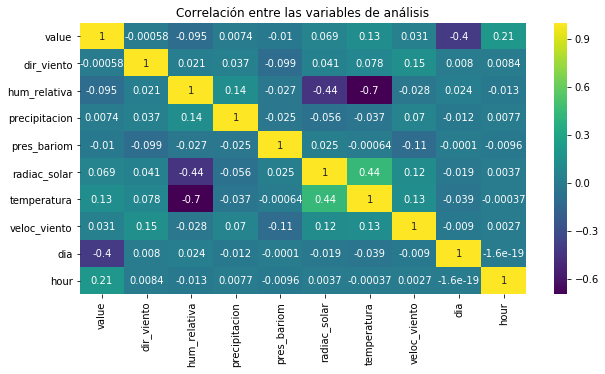

In [16]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True, cmap="viridis")
plt.title('Correlación entre las variables de análisis')
plt.show()

* **Definición del modelo**

> * **Preparación del dataset para uso de red LSTM (red neuronal recurrente)**

Esto implica enmarcar el conjunto de datos como un problema de aprendizaje supervisado y normalizar las variables de entrada. Uno de los parámetros a fijar será el número de retardos a considerar para realizar la predicción sobre el instante t.

A continuación definimos una función que dado el dataset a transformar y el nº de retardos pasados a considerar (también es posible llevar a cabo la predicción para t+n siendo este valor n modificable) convierte nuestro problema en uno de aprendizaje supervisado.

Antes de aplicar esta función sobre nuestro dataset, debemos estandarizar nuestras variables explicativas. Para ello usaremos el transformador `MinMaxScaler()`, muy habitual en el tratamiento de redes neuronales convirtiendo los valores a escalas (-1,1) y aplicando como función de activación la tangente hiperbólica. Más adelante, tendremos que deshacer este cambio para obtener valores reales.

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

scaler_filename = "scaler.save"

class LSTMPreprocessing(object):
    """
        Clase que implementa los pasos a seguir para transformar un dataset limpio de valores NaN y 
        apto para utilizar como serie temporal en un dataset de entrada para un modelo de aprendizaje supervisado, en este caso, para una red neuronal LSTM
    """
    
    def __init__(self, data):
        """
            Constructor
            @param: data Dataset a preprocesar
        """
        self.data = data
    
    def df_preprocessing(self):
        """
            Función que realiza la estandarización de las características numéricas. 
            Para ello usaremos el codificador MinMaxScaler()
        """
        values = self.data.values
        values = values.astype('float32')
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaler = scaler.fit(values)
        return scaler, scaler.transform(values)
        
    
    def df_to_supervised(self, data_preprocess, n_in = 1, n_out = 1, dropnan = True):
        """
            Función que devuelve un pandas dataframe listo para aplicar LSTM
            
            @param: data_preprocess Resultado de la función anterior.
            @param: n_in Número de retardos a considerar.
            @param: n_out Número de instantes t+n a predecir (por defecto, únicamente el instante t)
        """
        n_vars = data_preprocess.shape[1]
        data_preprocess = pd.DataFrame(data_preprocess)
        cols, names = [], []
        # cálculo de retardos anteriores al instante t
        for i in range(n_in, 0, -1):
            cols.append(data_preprocess.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # cálculo de las predicciones a realizar
        for i in range(n_out):
            cols.append(data_preprocess.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # unión
        data_df = pd.concat(cols, axis=1)
        data_df.columns = names
        # eliminación NaN
        if dropnan:
            data_df.dropna(inplace=True)
        # eliminación variables en el instante t pues sólo queremos predecir el consumo (var1)
        columns_to_drop = data_df.columns[[i for (i,c) in enumerate(data_df.columns) if c == 'var1(t)'][0]+1:]
        data_df = data_df.drop(columns_to_drop, axis=1)
        inicio = datetime(2019, 1, 2, 0, 0)
        data_df.index = [datetime.strftime(inicio + timedelta(hours=h), "%Y-%m-%d %H:%M:%S") for h in range(data_df.shape[0])]
        return data_df

data_preprocess = LSTMPreprocessing(data)
scaler = data_preprocess.df_preprocessing()[0]
joblib.dump(scaler, scaler_filename) # guardamos el proceso de estandarización
data_preprocess_numeric = data_preprocess.df_preprocessing()[1]
data_LSTM = data_preprocess.df_to_supervised(data_preprocess_numeric, 24)
print("Registros del dataset:", data_LSTM.shape[0])
data_LSTM.tail()

Registros del dataset: 8736


,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),...,var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t)
2019-12-31 19:00:00,-0.670213,-0.699164,0.48,-1.0,0.972660,-0.998084,-0.674300,-0.387429,-1.0,0.652174,...,-0.805014,0.46,-1.0,0.993691,-1.0,-0.572519,-0.291429,-0.75,0.565217,-0.057920
2019-12-31 20:00:00,-0.676123,-0.571031,0.44,-1.0,0.968454,-1.000000,-0.536896,-0.462857,-1.0,0.739130,...,-0.671309,0.34,-1.0,0.993691,-1.0,-0.628499,-0.776000,-0.75,0.652174,-0.235225
2019-12-31 21:00:00,-0.689125,-0.732591,0.52,-1.0,0.983176,-0.998084,-0.541985,-0.536000,-1.0,0.826087,...,-0.922006,0.12,-1.0,0.995794,-1.0,-0.536896,-0.798857,-0.75,0.739130,-0.392435
2019-12-31 22:00:00,-0.702128,0.877437,0.58,-1.0,0.987382,-0.998084,-0.511450,-0.936000,-1.0,0.913043,...,-0.604457,0.26,-1.0,0.995794,-1.0,-0.623410,-0.622857,-0.75,0.826087,-0.567376
2019-12-31 23:00:00,-0.697399,-0.409471,0.72,-1.0,0.989485,-1.000000,-0.557252,-0.924571,-1.0,1.000000,...,0.013928,0.80,-1.0,0.997897,-1.0,-0.684478,-0.931429,-0.75,0.913043,-0.598109


> **Definición y ajuste del modelo**

En esta sección, ajustaremos un LSTM en los datos de entrada multivariados.

Primero, debemos dividir el conjunto de datos preparado en connjunto de entrenamiento y conjunto de prueba. 

Además, los input deben tener el formato 3D esperado por los LSTM, `[muestras, pasos de tiempo, características]`.

>> **Estrategia de validación.** Recordamos que utilizaremos aquí la estrategia de validación de **Walk Forward Validation** implementada al inicio del cuaderno de trabajo. Para ello, debemos decidir el valor de los parámetros que toma esta clase definida:

    Initial: Consideraremos el 90% de los días del histórico como conjunto de entrenamiento.
    Horizon: El conjunto test constituirá los próximos 2 días.
    Period: Nº de registros incorporados en cada iteración.

In [18]:
print("Columna de análisis:", data_LSTM.columns[-1])

Columna de análisis: var1(t)


> **Entrenamiento del modelo**

In [20]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

class LSTMModel(object):
    """
        Clase que implementa la etapa de modelado: definición, entrenamiento y evaluación de la red neuronal
    """
    def __init__(self, data):
        """
            Constructor
        
            @param: data Dataset preprocesado
        """
        self.data = data
        
    def model(self, pct_days_ini_train = 0.9, n_horizon = 24, n_period = 24, pct_val_size = 0.2, n_epochs = 50, 
             n_batch_size = 72, n_patience = 3):
        """
            Separación entrenamiento test
            
            @param: pct_days_ini_train % de días pertenecientes a la primera ventana de entrenamiento
            @param: n_horizon Nº registros a predecir en cada iteración
            @param: n_period Nº registros a introducir en cada pliegue
            @param: pct_val_size Tamaño del conjunto de validación en cada entrenamiento
            @param: n_epochs Iteraciones a realizar
            @param: n_batch_size Tamaño de cada bloque de datos a actualizar los pesos de las neuronas
            @param: n_patience Número de epocas a considerar sin mejora en el error en EarlyStopping
        """
        X = data_LSTM.iloc[:,:-1]
        y = data_LSTM.iloc[:,-1]

        dates = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date() for x in X.index]
        dates = list(dict.fromkeys(dates))

        n_train = round(len(dates) * pct_days_ini_train) * 24 # 90% días y 24h por dia
        n_horizon = n_horizon # el conjunto test serán 2 días vista
        n_period = n_period # incluiremos 2 días en la siguiente iteración
        
        tscv = expanding_window(initial = n_train, horizon = n_horizon, period = n_period)
        predictions = []
        mae_pliegues = []
        mape_pliegues = []
        i = 0
        for train_index, test_index in tscv.split(X):
            
            ## Conjunto entrenamiento y test
            train_X = X.iloc[train_index,:]
            train_y = y[train_index]
            test_X = X.iloc[test_index,:]
            test_y = y[test_index]
            ## Cambio de formato
            train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
            test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
            
            ## Conjunto de validación
            val_size = int(pct_val_size * len(train_X))
            val_X = train_X[:val_size]
            val_y = train_y[:val_size]
            train_X = train_X[val_size:]
            train_y = train_y[val_size:]
            print("Tamaño de los conjuntos:")
            print("- Entrenamiento:", train_X.shape)
            print("- Validación:", val_X.shape)
            print("- Test:", test_X.shape)
            
            # Definición del modelo
            model = Sequential()
            model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), activation='tanh'))
            model.add(Dropout(0.5))
            model.add(Dense(1, activation='tanh'))
            opt = Adam(lr = 1e-4)
            model.compile(loss='mae', optimizer = opt)
            
            # Entrenamiento del modelo / Conjunto de validación
            print("Entrenamiento-validación pliegue:", i)
            print("Aplicando técnica de regularización: Early Stopping")
            print("Fase I")
            ## fase I
            model.fit(train_X, train_y, epochs = n_epochs, batch_size = n_batch_size, 
                     validation_data = (val_X, val_y), callbacks = [EarlyStopping(monitor = 'val_loss', 
                                                                                  patience = n_patience)])
            num_epochs_early_stopping = len(model.history.epoch)
            print("Número de iteraciones a considerar tras la regularización Early Stopping:", num_epochs_early_stopping)
            print("Fase II")
            train_val_X = np.concatenate((train_X, val_X))
            train_val_y = np.concatenate((train_y, val_y))
            model.fit(train_val_X, train_val_y, epochs = num_epochs_early_stopping, batch_size = n_batch_size)
            
            # Predicción en el conjunto test (horizon) - Evaluación del rendimiento en el conjunto horizon
            print("Evaluación del rendimiento del modelo entrenado sobre el pliegue:", i)
            yhat = model.predict(test_X)
            
            test_X_inv = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = pd.concat([pd.DataFrame(yhat), pd.DataFrame(test_X_inv[:,:9])], axis=1)#.values
            inv_y = pd.concat([pd.DataFrame(test_y.tolist()), pd.DataFrame(test_X_inv[:,:9])], axis=1)#.values
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_y = scaler.inverse_transform(inv_y)
            inv_yhat = inv_yhat[:,0]
            predictions.append(inv_yhat.tolist()) # almacenamos la predicción
            
            inv_y = inv_y[:,0]
            df_y = pd.DataFrame({'true': inv_y, 'pred': inv_yhat})
            
            mae_test_LSTM = mean_absolute_error(df_y['true'], df_y['pred'])
            mape_test_LSTM = np.mean(np.abs((df_y['true'] - df_y['pred']) / df_y['true'])) * 100
            
            mae_pliegues.append(mae_test_LSTM)
            mape_pliegues.append(mape_test_LSTM)
            
            # Aumentamos el conteo
            i += 1
        
        return predictions, mae_pliegues, mape_pliegues
    
obj_LSTM = LSTMModel(data_LSTM)
predictions_LSTM, mae_LSTM, mape_LSTM = obj_LSTM.model()


Tamaño de los conjuntos:
- Entrenamiento: (6298, 1, 240)
- Validación: (1574, 1, 240)
- Test: (24, 1, 240)
Entrenamiento-validación pliegue: 0
Aplicando técnica de regularización: Early Stopping
Fase I
Train on 6298 samples, validate on 1574 samples
Epoch 1/50
6298/6298 [==============================] - 3s 430us/step - loss: 0.3451 - val_loss: 0.1851
Epoch 2/50
6298/6298 [==============================] - 1s 111us/step - loss: 0.2265 - val_loss: 0.1344
Epoch 3/50
6298/6298 [==============================] - 1s 114us/step - loss: 0.1912 - val_loss: 0.1241
Epoch 4/50
6298/6298 [==============================] - 1s 112us/step - loss: 0.1745 - val_loss: 0.1148
Epoch 5/50
6298/6298 [==============================] - 1s 115us/step - loss: 0.1611 - val_loss: 0.1048
Epoch 6/50
6298/6298 [==============================] - 1s 115us/step - loss: 0.1514 - val_loss: 0.1030
Epoch 7/50
6298/6298 [==============================] - 1s 111us/step - loss: 0.1445 - val_loss: 0.0931
Epoch 8/50
6298/6298 [

Tamaño de los conjuntos:
- Entrenamiento: (6356, 1, 240)
- Validación: (1588, 1, 240)
- Test: (24, 1, 240)
Entrenamiento-validación pliegue: 3
Aplicando técnica de regularización: Early Stopping
Fase I
Train on 6356 samples, validate on 1588 samples
Epoch 1/50
6356/6356 [==============================] - 4s 578us/step - loss: 0.4045 - val_loss: 0.2123
Epoch 2/50
6356/6356 [==============================] - 1s 115us/step - loss: 0.2407 - val_loss: 0.1377
Epoch 3/50
6356/6356 [==============================] - 1s 113us/step - loss: 0.1943 - val_loss: 0.1368
Epoch 4/50
6356/6356 [==============================] - 1s 117us/step - loss: 0.1741 - val_loss: 0.1277
Epoch 5/50
6356/6356 [==============================] - 1s 122us/step - loss: 0.1600 - val_loss: 0.1064
Epoch 6/50
6356/6356 [==============================] - 1s 124us/step - loss: 0.1526 - val_loss: 0.1058
Epoch 7/50
6356/6356 [==============================] - 1s 115us/step - loss: 0.1451 - val_loss: 0.1176
Epoch 8/50
6356/6356 [

Número de iteraciones a considerar tras la regularización Early Stopping: 43
Fase II
Epoch 1/43
7968/7968 [==============================] - 1s 109us/step - loss: 0.0852
Epoch 2/43
7968/7968 [==============================] - 1s 111us/step - loss: 0.0844
Epoch 3/43
7968/7968 [==============================] - 1s 120us/step - loss: 0.0827
Epoch 4/43
7968/7968 [==============================] - 1s 117us/step - loss: 0.0832
Epoch 5/43
7968/7968 [==============================] - 1s 110us/step - loss: 0.0819
Epoch 6/43
7968/7968 [==============================] - 1s 112us/step - loss: 0.0804
Epoch 7/43
7968/7968 [==============================] - 1s 108us/step - loss: 0.0809
Epoch 8/43
7968/7968 [==============================] - 1s 112us/step - loss: 0.0810
Epoch 9/43
7968/7968 [==============================] - 1s 110us/step - loss: 0.0802
Epoch 10/43
7968/7968 [==============================] - 1s 115us/step - loss: 0.0804
Epoch 11/43
7968/7968 [==============================] - 1s 107u

Train on 6413 samples, validate on 1603 samples
Epoch 1/50
6413/6413 [==============================] - 5s 742us/step - loss: 0.3650 - val_loss: 0.1865
Epoch 2/50
6413/6413 [==============================] - 1s 122us/step - loss: 0.2172 - val_loss: 0.1479
Epoch 3/50
6413/6413 [==============================] - 1s 125us/step - loss: 0.1889 - val_loss: 0.1379
Epoch 4/50
6413/6413 [==============================] - 1s 124us/step - loss: 0.1717 - val_loss: 0.1211
Epoch 5/50
6413/6413 [==============================] - 1s 122us/step - loss: 0.1598 - val_loss: 0.1118
Epoch 6/50
6413/6413 [==============================] - 1s 132us/step - loss: 0.1492 - val_loss: 0.0995
Epoch 7/50
6413/6413 [==============================] - 1s 123us/step - loss: 0.1430 - val_loss: 0.1001
Epoch 8/50
6413/6413 [==============================] - 1s 123us/step - loss: 0.1357 - val_loss: 0.0936
Epoch 9/50
6413/6413 [==============================] - 1s 123us/step - loss: 0.1321 - val_loss: 0.0872
Epoch 10/50
6413

Epoch 26/50
6432/6432 [==============================] - 1s 127us/step - loss: 0.0966 - val_loss: 0.0654
Epoch 27/50
6432/6432 [==============================] - 1s 123us/step - loss: 0.0963 - val_loss: 0.0662
Número de iteraciones a considerar tras la regularización Early Stopping: 27
Fase II
Epoch 1/27
8040/8040 [==============================] - 1s 115us/step - loss: 0.0941
Epoch 2/27
8040/8040 [==============================] - 1s 114us/step - loss: 0.0931
Epoch 3/27
8040/8040 [==============================] - 1s 114us/step - loss: 0.0921
Epoch 4/27
8040/8040 [==============================] - 1s 119us/step - loss: 0.0918
Epoch 5/27
8040/8040 [==============================] - 1s 119us/step - loss: 0.0912
Epoch 6/27
8040/8040 [==============================] - 1s 117us/step - loss: 0.0889
Epoch 7/27
8040/8040 [==============================] - 1s 114us/step - loss: 0.0899
Epoch 8/27
8040/8040 [==============================] - 1s 114us/step - loss: 0.0877
Epoch 9/27
8040/8040 [===

Epoch 9/43
8064/8064 [==============================] - 1s 130us/step - loss: 0.0813
Epoch 10/43
8064/8064 [==============================] - 1s 120us/step - loss: 0.0813
Epoch 11/43
8064/8064 [==============================] - 1s 126us/step - loss: 0.0798
Epoch 12/43
8064/8064 [==============================] - 1s 121us/step - loss: 0.0793
Epoch 13/43
8064/8064 [==============================] - 1s 121us/step - loss: 0.0797
Epoch 14/43
8064/8064 [==============================] - 1s 116us/step - loss: 0.0785
Epoch 15/43
8064/8064 [==============================] - 1s 121us/step - loss: 0.0780
Epoch 16/43
8064/8064 [==============================] - 1s 123us/step - loss: 0.0782
Epoch 17/43
8064/8064 [==============================] - 1s 123us/step - loss: 0.0772
Epoch 18/43
8064/8064 [==============================] - 1s 131us/step - loss: 0.0783
Epoch 19/43
8064/8064 [==============================] - 1s 119us/step - loss: 0.0766
Epoch 20/43
8064/8064 [==============================] 

6471/6471 [==============================] - 1s 144us/step - loss: 0.0844 - val_loss: 0.0561
Epoch 48/50
6471/6471 [==============================] - 1s 195us/step - loss: 0.0832 - val_loss: 0.0563
Epoch 49/50
6471/6471 [==============================] - 1s 139us/step - loss: 0.0830 - val_loss: 0.0549
Epoch 50/50
6471/6471 [==============================] - 1s 135us/step - loss: 0.0822 - val_loss: 0.0554
Número de iteraciones a considerar tras la regularización Early Stopping: 50
Fase II
Epoch 1/50
8088/8088 [==============================] - 1s 128us/step - loss: 0.0819
Epoch 2/50
8088/8088 [==============================] - 1s 129us/step - loss: 0.0811
Epoch 3/50
8088/8088 [==============================] - 1s 140us/step - loss: 0.0807
Epoch 4/50
8088/8088 [==============================] - 1s 134us/step - loss: 0.0798
Epoch 5/50
8088/8088 [==============================] - 1s 130us/step - loss: 0.0797
Epoch 6/50
8088/8088 [==============================] - 1s 134us/step - loss: 0.07

Epoch 39/50
6509/6509 [==============================] - 1s 148us/step - loss: 0.0892 - val_loss: 0.0547
Epoch 40/50
6509/6509 [==============================] - 1s 140us/step - loss: 0.0870 - val_loss: 0.0558
Epoch 41/50
6509/6509 [==============================] - 1s 141us/step - loss: 0.0868 - val_loss: 0.0542
Epoch 42/50
6509/6509 [==============================] - 1s 140us/step - loss: 0.0857 - val_loss: 0.0547
Epoch 43/50
6509/6509 [==============================] - 1s 141us/step - loss: 0.0860 - val_loss: 0.0549
Epoch 44/50
6509/6509 [==============================] - 1s 142us/step - loss: 0.0871 - val_loss: 0.0564
Número de iteraciones a considerar tras la regularización Early Stopping: 44
Fase II
Epoch 1/44
8136/8136 [==============================] - 1s 134us/step - loss: 0.0838
Epoch 2/44
8136/8136 [==============================] - 1s 129us/step - loss: 0.0841
Epoch 3/44
8136/8136 [==============================] - 1s 127us/step - loss: 0.0838
Epoch 4/44
8136/8136 [========

Train on 6548 samples, validate on 1636 samples
Epoch 1/50
6548/6548 [==============================] - 7s 1ms/step - loss: 0.3275 - val_loss: 0.1787
Epoch 2/50
6548/6548 [==============================] - 1s 151us/step - loss: 0.2295 - val_loss: 0.1416
Epoch 3/50
6548/6548 [==============================] - 1s 145us/step - loss: 0.1944 - val_loss: 0.1287
Epoch 4/50
6548/6548 [==============================] - 1s 147us/step - loss: 0.1733 - val_loss: 0.1110
Epoch 5/50
6548/6548 [==============================] - 1s 146us/step - loss: 0.1603 - val_loss: 0.1017
Epoch 6/50
6548/6548 [==============================] - 1s 146us/step - loss: 0.1479 - val_loss: 0.0916
Epoch 7/50
6548/6548 [==============================] - 1s 147us/step - loss: 0.1417 - val_loss: 0.0872
Epoch 8/50
6548/6548 [==============================] - 1s 157us/step - loss: 0.1341 - val_loss: 0.0895
Epoch 9/50
6548/6548 [==============================] - 1s 147us/step - loss: 0.1308 - val_loss: 0.0874
Epoch 10/50
6548/6

Epoch 13/50
6586/6586 [==============================] - 1s 158us/step - loss: 0.1184 - val_loss: 0.0773
Epoch 14/50
6586/6586 [==============================] - 1s 155us/step - loss: 0.1190 - val_loss: 0.0769
Epoch 15/50
6586/6586 [==============================] - 1s 157us/step - loss: 0.1137 - val_loss: 0.0739
Epoch 16/50
6586/6586 [==============================] - 1s 149us/step - loss: 0.1120 - val_loss: 0.0732
Epoch 17/50
6586/6586 [==============================] - 1s 156us/step - loss: 0.1099 - val_loss: 0.0749
Epoch 18/50
6586/6586 [==============================] - 1s 157us/step - loss: 0.1097 - val_loss: 0.0770
Epoch 19/50
6586/6586 [==============================] - 1s 152us/step - loss: 0.1065 - val_loss: 0.0691
Epoch 20/50
6586/6586 [==============================] - 1s 161us/step - loss: 0.1039 - val_loss: 0.0674
Epoch 21/50
6586/6586 [==============================] - 1s 154us/step - loss: 0.1046 - val_loss: 0.0671
Epoch 22/50
6586/6586 [==============================] 

Epoch 16/50
6624/6624 [==============================] - 1s 179us/step - loss: 0.1058 - val_loss: 0.0715
Epoch 17/50
6624/6624 [==============================] - 1s 173us/step - loss: 0.1050 - val_loss: 0.0703
Epoch 18/50
6624/6624 [==============================] - 1s 179us/step - loss: 0.1028 - val_loss: 0.0695
Epoch 19/50
6624/6624 [==============================] - 1s 175us/step - loss: 0.1004 - val_loss: 0.0688
Epoch 20/50
6624/6624 [==============================] - 1s 197us/step - loss: 0.1009 - val_loss: 0.0667
Epoch 21/50
6624/6624 [==============================] - 1s 178us/step - loss: 0.0991 - val_loss: 0.0671
Epoch 22/50
6624/6624 [==============================] - 1s 179us/step - loss: 0.0992 - val_loss: 0.0719
Epoch 23/50
6624/6624 [==============================] - 1s 177us/step - loss: 0.0968 - val_loss: 0.0641
Epoch 24/50
6624/6624 [==============================] - 1s 173us/step - loss: 0.0941 - val_loss: 0.0707
Epoch 25/50
6624/6624 [==============================] 

8304/8304 [==============================] - 1s 164us/step - loss: 0.0839
Epoch 17/29
8304/8304 [==============================] - 1s 155us/step - loss: 0.0814
Epoch 18/29
8304/8304 [==============================] - 1s 159us/step - loss: 0.0810
Epoch 19/29
8304/8304 [==============================] - ETA: 0s - loss: 0.079 - 1s 167us/step - loss: 0.0796
Epoch 20/29
8304/8304 [==============================] - 1s 169us/step - loss: 0.0814
Epoch 21/29
8304/8304 [==============================] - 1s 158us/step - loss: 0.0804
Epoch 22/29
8304/8304 [==============================] - 1s 159us/step - loss: 0.0794
Epoch 23/29
8304/8304 [==============================] - 1s 162us/step - loss: 0.0799
Epoch 24/29
8304/8304 [==============================] - 1s 164us/step - loss: 0.0795
Epoch 25/29
8304/8304 [==============================] - 1s 158us/step - loss: 0.0788
Epoch 26/29
8304/8304 [==============================] - 1s 149us/step - loss: 0.0793
Epoch 27/29
8304/8304 [===================

6701/6701 [==============================] - 1s 196us/step - loss: 0.1033 - val_loss: 0.0661
Epoch 22/50
6701/6701 [==============================] - 1s 196us/step - loss: 0.1006 - val_loss: 0.0664
Epoch 23/50
6701/6701 [==============================] - 1s 194us/step - loss: 0.0998 - val_loss: 0.0659
Epoch 24/50
6701/6701 [==============================] - 1s 192us/step - loss: 0.0998 - val_loss: 0.0674
Epoch 25/50
6701/6701 [==============================] - 1s 194us/step - loss: 0.0990 - val_loss: 0.0615
Epoch 26/50
6701/6701 [==============================] - 1s 191us/step - loss: 0.0975 - val_loss: 0.0653
Epoch 27/50
6701/6701 [==============================] - 1s 198us/step - loss: 0.0979 - val_loss: 0.0626
Epoch 28/50
6701/6701 [==============================] - 1s 192us/step - loss: 0.0956 - val_loss: 0.0640
Número de iteraciones a considerar tras la regularización Early Stopping: 28
Fase II
Epoch 1/28
8376/8376 [==============================] - 2s 180us/step - loss: 0.0940
Ep

Epoch 13/33
8400/8400 [==============================] - 2s 183us/step - loss: 0.0820
Epoch 14/33
8400/8400 [==============================] - 1s 177us/step - loss: 0.0811
Epoch 15/33
8400/8400 [==============================] - 2s 182us/step - loss: 0.0817
Epoch 16/33
8400/8400 [==============================] - 1s 176us/step - loss: 0.0801
Epoch 17/33
8400/8400 [==============================] - 2s 179us/step - loss: 0.0796
Epoch 18/33
8400/8400 [==============================] - 2s 182us/step - loss: 0.0798
Epoch 19/33
8400/8400 [==============================] - 2s 179us/step - loss: 0.0794
Epoch 20/33
8400/8400 [==============================] - 1s 178us/step - loss: 0.0794
Epoch 21/33
8400/8400 [==============================] - 1s 178us/step - loss: 0.0790
Epoch 22/33
8400/8400 [==============================] - 1s 178us/step - loss: 0.0784
Epoch 23/33
8400/8400 [==============================] - 1s 175us/step - loss: 0.0781
Epoch 24/33
8400/8400 [==============================]

8448/8448 [==============================] - 2s 194us/step - loss: 0.0813
Epoch 15/33
8448/8448 [==============================] - 2s 185us/step - loss: 0.0805
Epoch 16/33
8448/8448 [==============================] - 2s 186us/step - loss: 0.0798
Epoch 17/33
8448/8448 [==============================] - 2s 185us/step - loss: 0.0802
Epoch 18/33
8448/8448 [==============================] - 2s 192us/step - loss: 0.0794
Epoch 19/33
8448/8448 [==============================] - 2s 184us/step - loss: 0.0790
Epoch 20/33
8448/8448 [==============================] - 2s 185us/step - loss: 0.0784
Epoch 21/33
8448/8448 [==============================] - 2s 191us/step - loss: 0.0791
Epoch 22/33
8448/8448 [==============================] - 2s 192us/step - loss: 0.0774
Epoch 23/33
8448/8448 [==============================] - 2s 186us/step - loss: 0.0783
Epoch 24/33
8448/8448 [==============================] - 2s 184us/step - loss: 0.0777
Epoch 25/33
8448/8448 [==============================] - 2s 192us/

8520/8520 [==============================] - 2s 196us/step - loss: 0.0859
Epoch 17/17
8520/8520 [==============================] - 2s 205us/step - loss: 0.0865
Evaluación del rendimiento del modelo entrenado sobre el pliegue: 27
Tamaño de los conjuntos:
- Entrenamiento: (6836, 1, 240)
- Validación: (1708, 1, 240)
- Test: (24, 1, 240)
Entrenamiento-validación pliegue: 28
Aplicando técnica de regularización: Early Stopping
Fase I
Train on 6836 samples, validate on 1708 samples
Epoch 1/50
6836/6836 [==============================] - 13s 2ms/step - loss: 0.3437 - val_loss: 0.1772
Epoch 2/50
6836/6836 [==============================] - 1s 214us/step - loss: 0.2277 - val_loss: 0.1465
Epoch 3/50
6836/6836 [==============================] - 1s 214us/step - loss: 0.1958 - val_loss: 0.1283
Epoch 4/50
6836/6836 [==============================] - 2s 224us/step - loss: 0.1765 - val_loss: 0.1149
Epoch 5/50
6836/6836 [==============================] - 2s 232us/step - loss: 0.1607 - val_loss: 0.1093
E

Epoch 11/50
6855/6855 [==============================] - 2s 220us/step - loss: 0.1236 - val_loss: 0.0878
Epoch 12/50
6855/6855 [==============================] - 2s 228us/step - loss: 0.1185 - val_loss: 0.0790
Epoch 13/50
6855/6855 [==============================] - 2s 225us/step - loss: 0.1173 - val_loss: 0.0785
Epoch 14/50
6855/6855 [==============================] - 2s 224us/step - loss: 0.1156 - val_loss: 0.0766
Epoch 15/50
6855/6855 [==============================] - 1s 219us/step - loss: 0.1113 - val_loss: 0.0757
Epoch 16/50
6855/6855 [==============================] - 2s 232us/step - loss: 0.1109 - val_loss: 0.0744
Epoch 17/50
6855/6855 [==============================] - 2s 222us/step - loss: 0.1081 - val_loss: 0.0726
Epoch 18/50
6855/6855 [==============================] - 2s 224us/step - loss: 0.1069 - val_loss: 0.0716
Epoch 19/50
6855/6855 [==============================] - 2s 219us/step - loss: 0.1045 - val_loss: 0.0722
Epoch 20/50
6855/6855 [==============================] 

Epoch 9/50
6893/6893 [==============================] - 2s 250us/step - loss: 0.1287 - val_loss: 0.0875
Epoch 10/50
6893/6893 [==============================] - 2s 237us/step - loss: 0.1268 - val_loss: 0.0812
Epoch 11/50
6893/6893 [==============================] - 2s 245us/step - loss: 0.1234 - val_loss: 0.0815
Epoch 12/50
6893/6893 [==============================] - 2s 268us/step - loss: 0.1173 - val_loss: 0.0790
Epoch 13/50
6893/6893 [==============================] - 2s 269us/step - loss: 0.1177 - val_loss: 0.0768
Epoch 14/50
6893/6893 [==============================] - 2s 251us/step - loss: 0.1140 - val_loss: 0.0746
Epoch 15/50
6893/6893 [==============================] - 2s 261us/step - loss: 0.1116 - val_loss: 0.0742
Epoch 16/50
6893/6893 [==============================] - 2s 252us/step - loss: 0.1104 - val_loss: 0.0796
Epoch 17/50
6893/6893 [==============================] - 2s 223us/step - loss: 0.1085 - val_loss: 0.0733
Epoch 18/50
6893/6893 [==============================] -

8640/8640 [==============================] - 2s 219us/step - loss: 0.0836
Epoch 18/23
8640/8640 [==============================] - 2s 227us/step - loss: 0.0832
Epoch 19/23
8640/8640 [==============================] - 2s 217us/step - loss: 0.0825
Epoch 20/23
8640/8640 [==============================] - 2s 221us/step - loss: 0.0816
Epoch 21/23
8640/8640 [==============================] - 2s 238us/step - loss: 0.0812
Epoch 22/23
8640/8640 [==============================] - 2s 223us/step - loss: 0.0814
Epoch 23/23
8640/8640 [==============================] - 2s 221us/step - loss: 0.0800
Evaluación del rendimiento del modelo entrenado sobre el pliegue: 32
Tamaño de los conjuntos:
- Entrenamiento: (6932, 1, 240)
- Validación: (1732, 1, 240)
- Test: (24, 1, 240)
Entrenamiento-validación pliegue: 33
Aplicando técnica de regularización: Early Stopping
Fase I
Train on 6932 samples, validate on 1732 samples
Epoch 1/50
6932/6932 [==============================] - 15s 2ms/step - loss: 0.3200 - val_

### Evaluación del rendimiento en cada uno de los _k_ pliegues
---

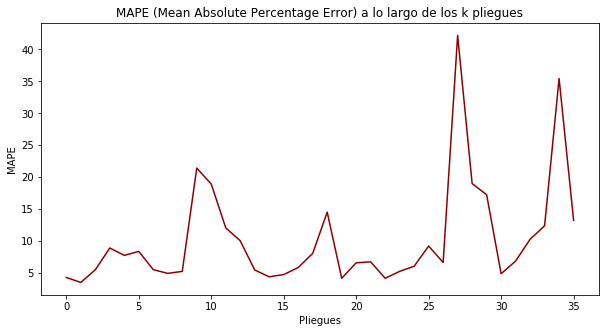

In [21]:
plt.figure(figsize=(10,5))
sns.lineplot(range(len(mape_LSTM)), mape_LSTM, color="darkred")
plt.title('MAPE (Mean Absolute Percentage Error) a lo largo de los k pliegues')
plt.xlabel('Pliegues')
plt.ylabel('MAPE')
plt.show()

In [22]:
print("MAPE: {} %".format(round(sum(mape_LSTM)/len(mape_LSTM), 2)))

MAPE: 10.28 %


Número de predicciones: 864


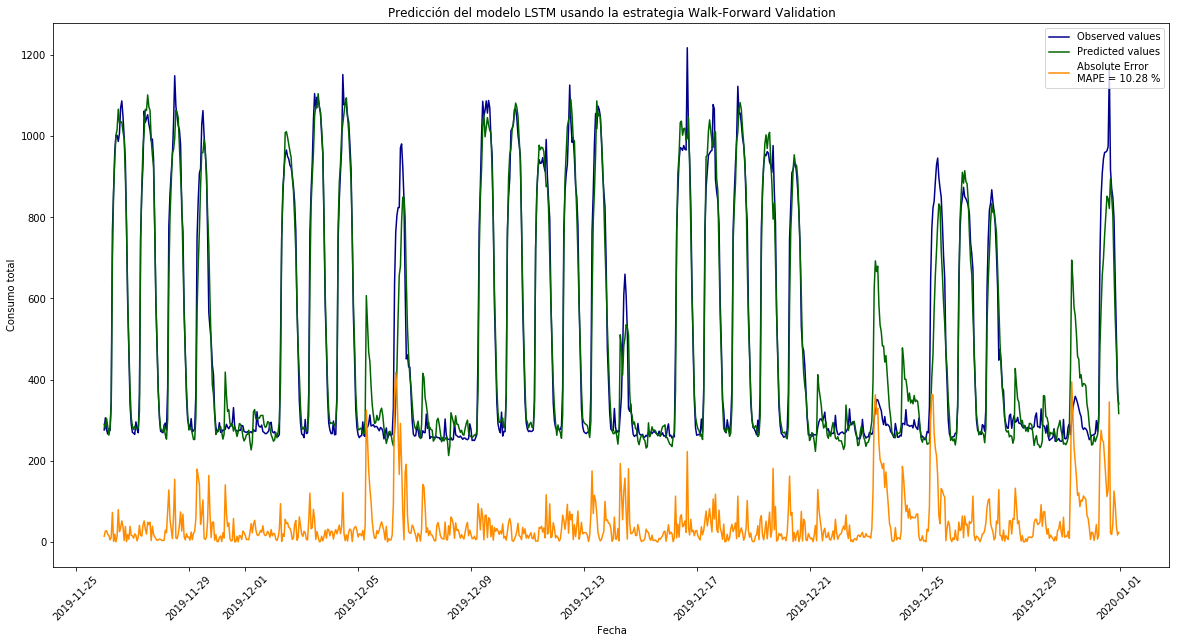

In [109]:
pred_LSTM = [x for l in predictions_LSTM for x in l]
print("Número de predicciones:", len(pred_LSTM))

data_to_predict = data.iloc[-len(pred_LSTM):, 0]
dates_to_predict = data_to_predict.index
value_real = data_to_predict.tolist()

plt.figure(figsize=(20,10))
sns.lineplot(dates_to_predict, value_real, color = "darkblue", label = "Observed values")
sns.lineplot(dates_to_predict, pred_LSTM, color = "darkgreen", label = "Predicted values")
sns.lineplot(dates_to_predict, [abs(x - y) for x,y in zip(value_real, pred_LSTM)], 
            color = "darkorange", label = "Absolute Error \nMAPE = {} %".format(round(sum(mape_LSTM)/len(mape_LSTM), 2)))
plt.title('Predicción del modelo LSTM usando la estrategia Walk-Forward Validation')
plt.xlabel('Fecha')
plt.xticks(rotation='45')
plt.ylabel('Consumo total')
plt.legend(loc = 'best')
plt.show()